In [1]:
from astropy.io import fits

import pysr
import pyccl as ccl
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc
from numcosmo_py import sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
import timeit
Ncm.cfg_init()


Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
hdul_halos = fits.open("../halos/halos.fits")
hdul_ame = fits.open("richness_mcut_SNR 12_ame.fits")

logMmin = 13.5
logMmax = 15

table_halos = hdul_halos[1].data
table_ame = hdul_ame[1].data
table_halos = Table(table_halos[(table_halos['upid'] == -1)  &  (table_halos['Mvir'] >= 10**logMmin) & (table_halos['Mvir'] <= 10**logMmax)])
table_ame = Table(table_ame)

table_halos['Mvir'] = np.log10(table_halos['Mvir']/0.6774)

print(len(table_halos))
print(len(table_ame))
table_halos = unique(table_halos, keys=['redshift_R', 'RA' , 'DEC'])
print(len(table_halos))

hdu = fits.BinTableHDU(data=table_halos)
hdu.writeto('ame_halos.fits' , overwrite=True)

print("DEC max")
print(table_ame['DEC'].max())
print(table_halos['DEC'].max())
print('0')
print("DEC min")
print(table_ame['DEC'].min())
print(table_halos['DEC'].min())
print('0')
print("RA max")
print(table_ame['RA'].max())
print(table_halos['RA'].max())
print('0')
print("RA min")
print(table_ame['RA'].min())
print(table_halos['RA'].min())
print('0')
print("z max")
print(table_ame['z'].max())
print(table_halos['redshift_R'].max())
print('0')
print("z min")
print(table_ame['z'].min())
print(table_halos['redshift_R'].min())

display(table_ame.columns)

154622
23751
154578
DEC max
69.987462659708
69.99916076660156
0
DEC min
20.00571528380776
20.00000762939453
0
RA max
229.99483480331588
229.99945068359375
0
RA min
110.00560235552096
110.00056457519531
0
z max
0.6587940911577925
0.6646266720685149
0
z min
0.0462011092646255
0.011118923724330439


<TableColumns names=('ID','RA','DEC','z','z_err','SNR','SNR_ORIG','richness','radius','rank','Rc','R_ame','R_ame_err')>

 ## Initializing cosmology object

In [3]:
area = 4109.3
cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("H0", 67.74)
cosmo.param_set_by_name("Omegab", 0.0486)
cosmo.param_set_by_name("Omegac",0.3089 - 0.0486) #0.2603
cosmo.param_set_by_name("Omegak", 0.00)
cosmo.param_set_by_name("w", -1.0) #-1.0


prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA",3.0116707481421923)
prim.param_set_by_name("n_SA", 0.9667)


reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

 ## Matching halos-detections  by proximity

In [4]:
%%time
halo_coordinates = {"RA":"RA" , "DEC":"DEC" , "z":"redshift_R"}
halo_properties  = {"Mvir":"log10M"}

detections_coordinates =  {"RA":"RA" , "DEC":"DEC" , "z":"z"}
detections_properties  = {"R_ame":"R" , "z_err":"z_err" , "R_ame_err":"R_err" , "SNR":"SNR"}



halos = sky_match.SkyMatch(query_data=table_halos, query_coordinates=halo_coordinates,match_data=table_ame,
                   match_coordinates=detections_coordinates)

detections = halos.invert_query_match()





halos_matched =  halos.match_2d(cosmo, 100 ,distance_method= sky_match.DistanceMethod.QUERY_RADIUS)
detections_matched =  detections.match_2d(cosmo, 100,distance_method= sky_match.DistanceMethod.MATCH_RADIUS)


mask_halos = halos_matched.filter_mask_by_redshift_proximity(sigma_z= 0.0, match_sigma_z_column='z_err') & halos_matched.filter_mask_by_distance(1)
mask_detections = detections_matched.filter_mask_by_redshift_proximity(sigma_z= 0.0, query_sigma_z_column='z_err') & detections_matched.filter_mask_by_distance(1)


halos_table = halos_matched.to_table_complete(query_properties=halo_properties , match_properties=detections_properties,mask=mask_halos)
detections_table = detections_matched.to_table_complete(query_properties=detections_properties , match_properties=halo_properties,mask=mask_detections)


unique_halos = halos_matched.select_best(mask=mask_halos , selection_criteria=sky_match.SelectionCriteria.DISTANCES)
unique_detections = detections_matched.select_best(mask=mask_detections , selection_criteria=sky_match.SelectionCriteria.MORE_MASSIVE , more_massive_column='Mvir')

unique_halos_table = halos_matched.to_table_best(best=unique_halos , query_properties=halo_properties , match_properties=detections_properties)
unique_detections_table = detections_matched.to_table_best(best=unique_detections , query_properties=detections_properties , match_properties=halo_properties)

cross_indices = unique_halos.get_cross_match_indices(unique_detections)
cross = Table(names=(unique_halos_table.columns) , dtype=tuple([unique_halos_table.columns[i].dtype for i in range(len(unique_halos_table.columns))]))
for halo in cross_indices:
    cross_halo = unique_halos_table[unique_halos_table['ID'] == halo]
    cross.add_row(cross_halo[0])


print( "Number of halos: %i" % (len(halos_table)))
print( "Number of detections: %i" % (len(detections_table)))
print( "Number of halos that matched a detection: %i" % (len(unique_halos_table)))
print( "Number of detections that matched a halo: %i" %  (len(unique_detections_table)))
print( "Number of cross matches: %i" %  (len(cross)))

Number of halos: 154578
Number of detections: 23751
Number of halos that matched a detection: 19448
Number of detections that matched a halo: 18298
Number of cross matches: 18298
CPU times: user 42.7 s, sys: 2.57 s, total: 45.3 s
Wall time: 45.8 s


In [5]:
def completness_purity(cat1 ,cat2 , var1_int, var2_int, var1 , var2):
    """
    Calculates the ratio of cross-matching in given two observable bins 
    

    """
    var1_bin         = [ (var1_int[i] + var1_int[i+1])/2 for i in range(len(var1_int)-1)]
    var2_bin         = [ (var2_int[i] + var2_int[i+1])/2 for i in range(len(var2_int)-1)]
    ratio            = []

    for i in range(len(var1_int)-1):
        cat1_number_bin2 = []
        cat2_number_bin2 = []
        for j in range(len(var2_int)-1):
            cat1_number_bin2.append(len(cat1[(cat1[var1] >= var1_int[i]) & (cat1[var1] <= var1_int[i+1]) & (cat1[var2] >= var2_int[j])
                                    & (cat1[var2] <= var2_int[j+1])]))
            
            
            cat2_number_bin2.append(len(cat2[(cat2[var1] >= var1_int[i]) & (cat2[var1] <= var1_int[i+1]) & (cat2[var2] >= var2_int[j]) & (cat2[var2] <= var2_int[j+1])]))

        cat1_number_bin2 = np.array(cat1_number_bin2)
        cat2_number_bin2 = np.array(cat2_number_bin2)

        ratio.append(cat1_number_bin2/cat2_number_bin2)

    
    return  np.array(var1_bin) ,  np.array(var2_bin) ,  np.array(ratio)

# Completeness 

 ## Completeness intervals construction

In [6]:
#2D color plot
z_2d      = np.linspace(table_halos['redshift_R'].min() , table_halos['redshift_R'].max() ,7)
log10M_2d = np.linspace(table_halos['Mvir'].min() , table_halos['Mvir'].max() ,7)

#Plots in z
z_z      = np.linspace(table_halos['redshift_R'].min() , table_halos['redshift_R'].max() ,10)
log10M_z = np.linspace(table_halos['Mvir'].min() , table_halos['Mvir'].max() ,5)

#Plots in log10M
z_M      = np.linspace(table_halos['redshift_R'].min() , table_halos['redshift_R'].max() ,5)
log10M_M = np.linspace(table_halos['Mvir'].min() , table_halos['Mvir'].max() ,10)



 ## One-way Completeness
  The **one-way completeness** $c_1(M, z)$ of a halo catalog is defined as the fraction of dark matter halos identified as a detection by the algorithm within a specific mass range $M$  and redshift $z$. It is calculated as follows [C. Knobel et al 2009 ApJ 697 1842](
    https://iopscience.iop.org/article/10.1088/0004-637X/697/2/1842/meta):
$$
c_1 = \frac{\mathcal{A}_1 \left[ N^{halo}(M,z) \to N^{det} \right]}{N^{halo}(M,z)}.
$$
Where:
$\mathcal{A}_1 \left[ N^{halo}(M,z) \to N^{det} \right]$ : Number of halos with mass $M$ and redshift $z$ that were correctly matched to clusters detected in the catalog.
$N^{halo}(M,z)$: Total number of halos with mass $M$ and redshift $z$ present in the dataset.

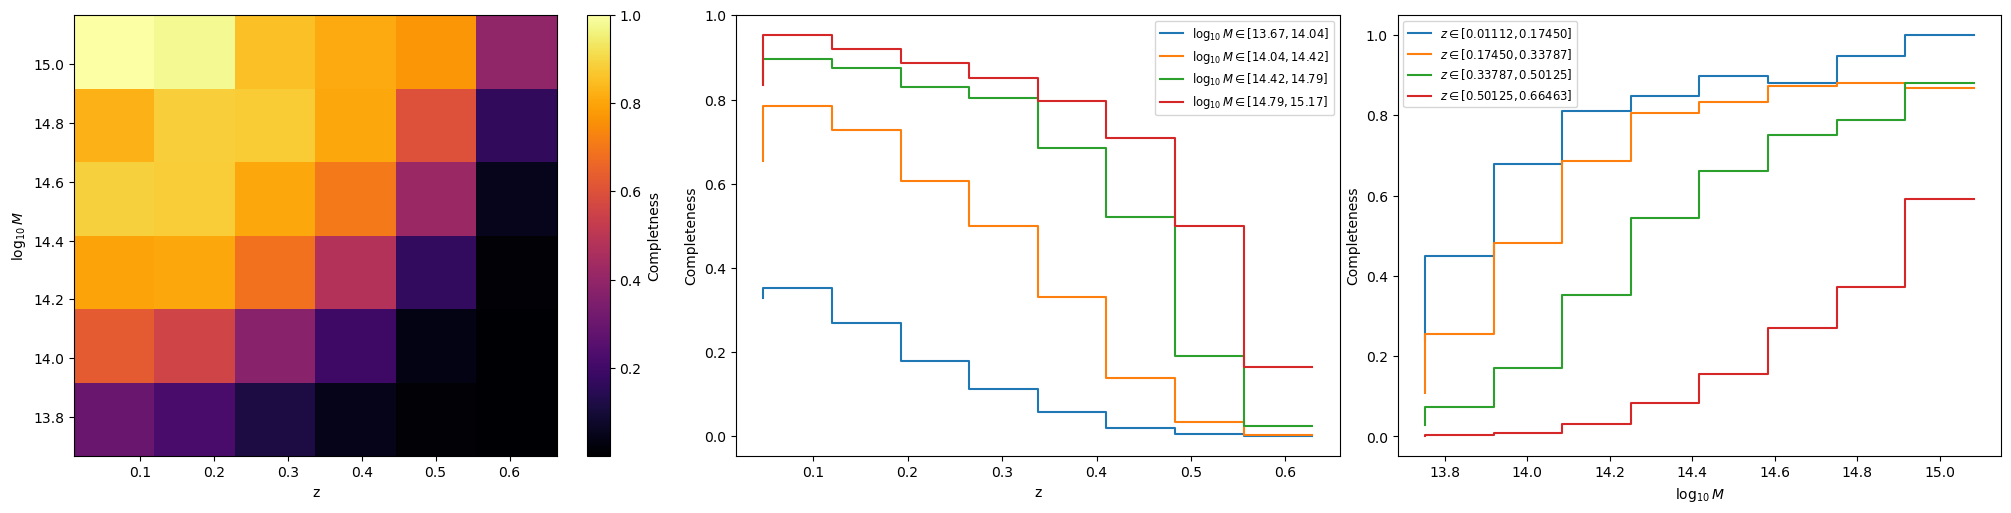

In [7]:
z_bin_1c_2d , M_bin_1c_2d, ratio_1c_2d = completness_purity(unique_halos_table , halos_table , z_2d , log10M_2d , 'z','log10M')

M_grid_1c_2d, z_grid_1c_2d = np.meshgrid(M_bin_1c_2d, z_bin_1c_2d)
C = ratio_1c_2d.reshape(len(M_bin_1c_2d),len(z_bin_1c_2d),)

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

fig.subplots_adjust(wspace=0.5)
fig.tight_layout()


c = ax1.pcolor(z_grid_1c_2d,M_grid_1c_2d,   C , cmap='inferno')
ax1.set_xlabel("z")
ax1.set_ylabel(r"$\log_{10}M $")
fig.colorbar(c, ax=ax1, label='Completness',location='right')


z_bin_1c_z , M_bin_1c_z , ratio_1c_z = completness_purity(unique_halos_table , halos_table , z_z , log10M_z , 'z','log10M')

for i in range(len(M_bin_1c_z)):
    mass_bin = []
    for j in range(len(z_bin_1c_z)):
        mass_bin.append(ratio_1c_z[j][i])

    ax2.step(z_bin_1c_z ,mass_bin , label=r"$\log_{10}M \in [%.2f ,%.2f]$" % (log10M_z[i] ,log10M_z[i+1]))
    ax2.set_xlabel("z")
    ax2.set_ylabel("Completeness")
    ax2.legend(loc=1, bbox_to_anchor=(1, 1),fontsize='small')


z_bin_1c_M , M_bin_1c_M , ratio_1c_M = completness_purity(unique_halos_table , halos_table , z_M , log10M_M , 'z','log10M')

for i in range(len(z_bin_1c_M)):
    redshift_bin = []
    for j in range(len(M_bin_1c_M)):
        redshift_bin.append(ratio_1c_M[i][j])
        
    ax3.step(M_bin_1c_M ,redshift_bin , label=r"$z \in [%.5f ,%.5f]$" % (z_M[i] ,z_M[i+1]))
    ax3.set_xlabel(r"$\log_{10}M$")
    ax3.set_ylabel("Completeness")
    
    # Put a legend to the right of the current axis
    ax3.legend(loc="upper left",fontsize='small')
plt.show()

 ## Two-way Completeness
  The **two-way completeness** $c_2(M, z)$ of a halo catalog is defined as the fraction of dark matter halos identified as a detection that has the same detection associated with that halos by the algorithm within a specific mass range $M$  and redshift $z$. It is calculated as follows [C. Knobel et al 2009 ApJ 697 1842](
    https://iopscience.iop.org/article/10.1088/0004-637X/697/2/1842/meta):
$$
c_2 = \frac{\mathcal{A}_2 \left[ N^{halo} \leftrightarrow  N^{det} \right]}{N^{halo}},
$$
Where:
$\mathcal{A}_2 \left[ N^{halo} \leftrightarrow  N^{det} \right]$ : Number of halos with mass $M$ and redshift $z$ that were correctly two way matched to clusters detected in the catalog.
$N^{halo}(M,z)$: Total number of halos with mass $M$ and redshift $z$ present in the dataset.

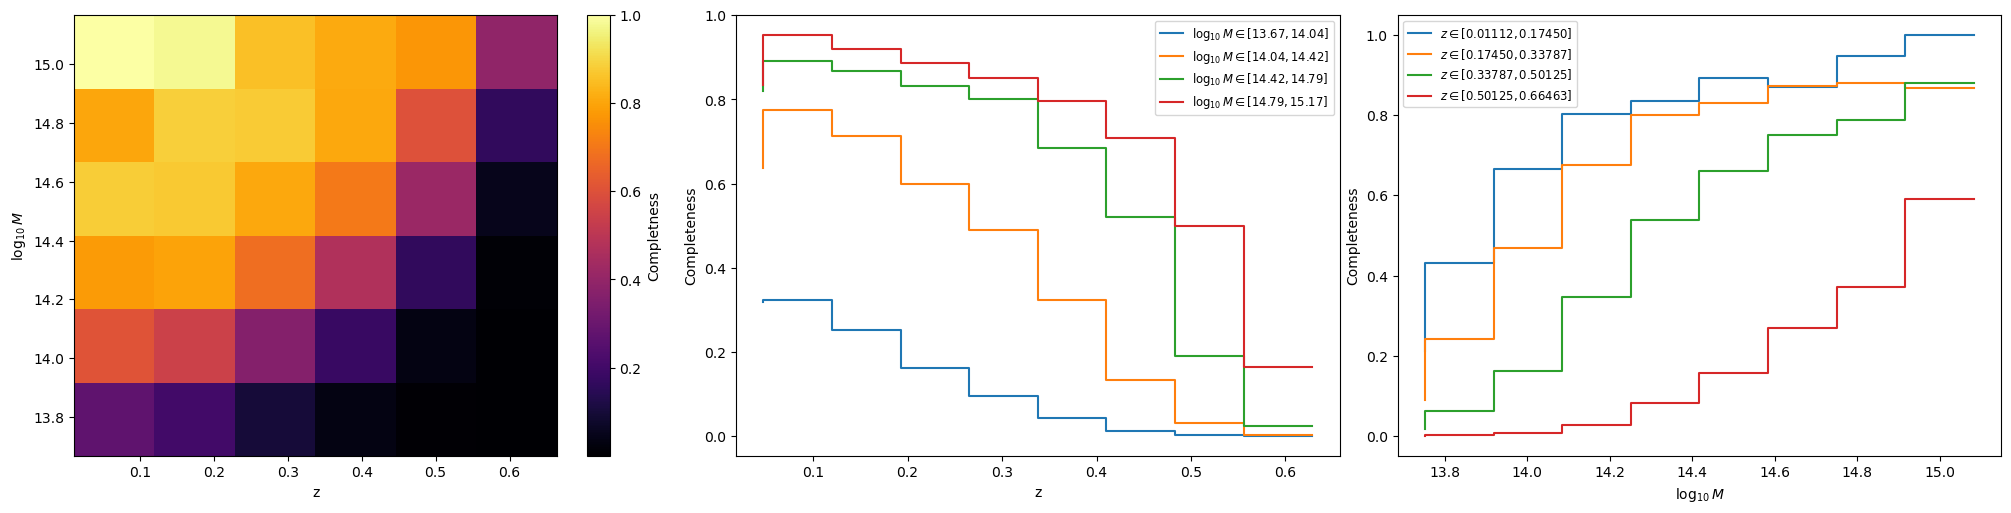

In [8]:
z_bin_2c_2d , M_bin_2c_2d , ratio_2c_2d = completness_purity(cross , halos_table , z_2d , log10M_2d , 'z','log10M')

M_grid_2c_2d, z_grid_2c_2d = np.meshgrid(M_bin_2c_2d, z_bin_2c_2d)
C = ratio_2c_2d.reshape(len(M_bin_2c_2d),len(z_bin_2c_2d),)

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

fig.subplots_adjust(wspace=0.5)
fig.tight_layout()


c = ax1.pcolor(z_grid_2c_2d, M_grid_2c_2d,   C , cmap='inferno')
ax1.set_xlabel("z")
ax1.set_ylabel(r"$\log_{10}M $")
fig.colorbar(c, ax=ax1, label='Completness',location='right')


z      = np.linspace(table_halos['redshift_R'].min() , table_halos['redshift_R'].max() ,50)
log10M = np.linspace(np.log10(table_halos['Mvir'].min()) , np.log10(table_halos['Mvir'].max()) ,5)
z_bin_2c_z , M_bin_2c_z , ratio_2c_z = completness_purity(cross , halos_table , z_z , log10M_z , 'z','log10M')

for i in range(len(M_bin_2c_z)):
    mass_bin = []
    for j in range(len(z_bin_2c_z)):
        mass_bin.append(ratio_2c_z[j][i])

    ax2.step(z_bin_2c_z ,mass_bin , label=r"$\log_{10}M \in [%.2f ,%.2f]$" % (log10M_z[i] ,log10M_z[i+1]))
    ax2.set_xlabel("z")
    ax2.set_ylabel("Completeness")
    ax2.legend(loc=1, bbox_to_anchor=(1, 1),fontsize='small')


z      = np.linspace(table_halos['redshift_R'].min() , table_halos['redshift_R'].max() ,5)
log10M = np.linspace(np.log10(table_halos['Mvir'].min()) , np.log10(table_halos['Mvir'].max()) ,50)
z_bin_2c_M , M_bin_2c_M , ratio_2c_M = completness_purity(cross , halos_table , z_M , log10M_M , 'z','log10M')

for i in range(len(z_bin_2c_M)):
    redshift_bin = []
    for j in range(len(M_bin_2c_M)):
        redshift_bin.append(ratio_2c_M[i][j])
        
    ax3.step(M_bin_2c_M ,redshift_bin , label=r"$z \in [%.5f ,%.5f]$" % (z_M[i] ,z_M[i+1]))
    ax3.set_xlabel(r"$\log_{10}M$")
    ax3.set_ylabel("Completeness")
    
    # Put a legend to the right of the current axis
    ax3.legend(loc="upper left",fontsize='small')
plt.show()

 ## Overmerging
  The **Overmerging** $O(M, z)$ of a halo catalog is defined as the fraction of dark matter halos identified with multiple detections  by the algorithm within a specific mass range $M$  and redshift $z$. It is calculated as follows [C. Knobel et al 2009 ApJ 697 1842](
    https://iopscience.iop.org/article/10.1088/0004-637X/697/2/1842/meta):
$$
O =  1- \frac{c_2(M, z)}{c_1(M, z)}
$$

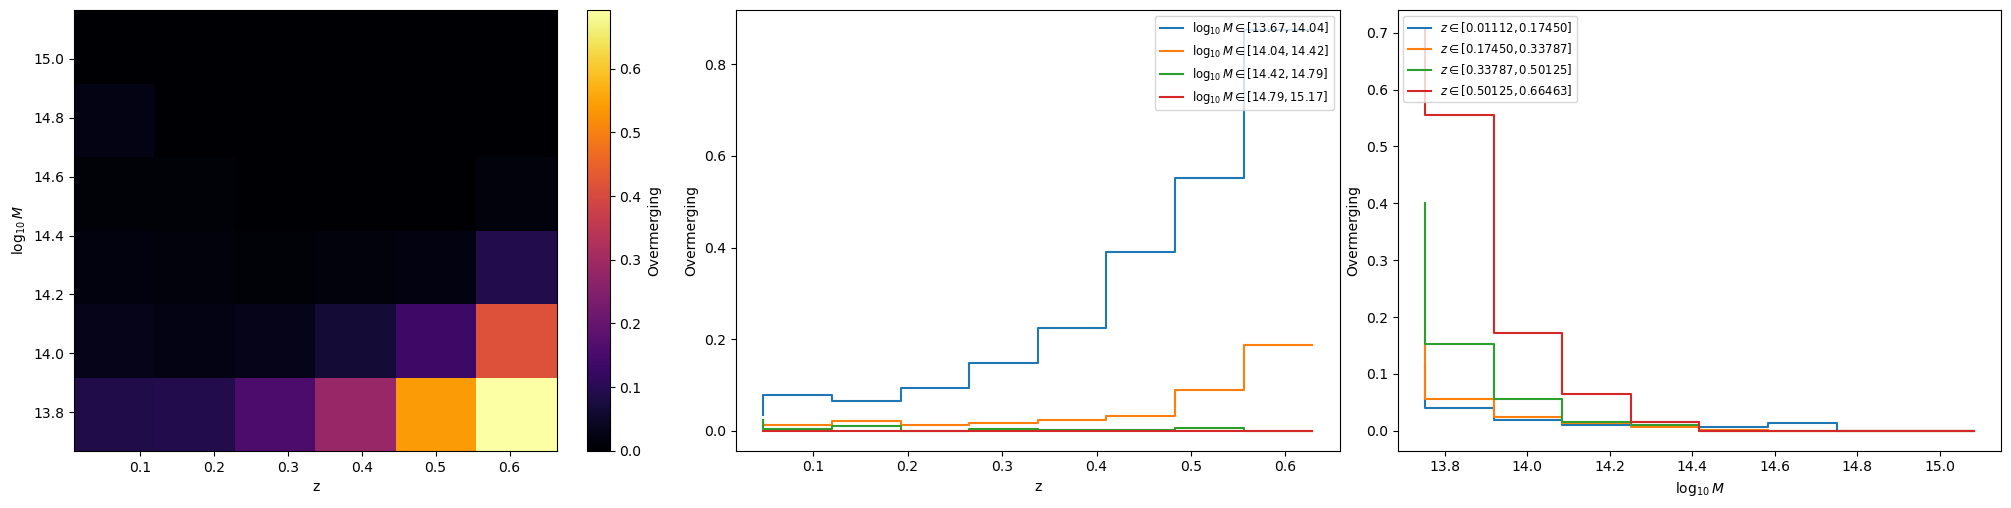

In [9]:
ratio_o_2d = np.array([ratio_2c_2d[i]/ratio_1c_2d[i] for i in range(len(ratio_2c_2d))])
ratio_o_2d = 1 -ratio_o_2d
M_grid_o_2d, z_grid_o_2d = np.meshgrid(M_bin_2c_2d, z_bin_2c_2d)
C = ratio_o_2d.reshape(len(M_bin_2c_2d),len(z_bin_2c_2d),)

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

fig.subplots_adjust(wspace=0.5)
fig.tight_layout()


c = ax1.pcolor(z_grid_o_2d,M_grid_o_2d,   C , cmap='inferno')
ax1.set_xlabel("z")
ax1.set_ylabel(r"$\log_{10}M $")
fig.colorbar(c, ax=ax1, label='Overmerging',location='right')


ratio_o_z = np.array([ratio_2c_z[i]/ratio_1c_z[i] for i in range(len(ratio_2c_z))])
ratio_o_z = 1 -ratio_o_z

for i in range(len(M_bin_2c_z)):
    mass_bin = []
    for j in range(len(z_bin_2c_z)):
        mass_bin.append(ratio_o_z[j][i])

    ax2.step(z_bin_2c_z ,mass_bin , label=r"$\log_{10}M \in [%.2f ,%.2f]$" % (log10M_z[i] ,log10M_z[i+1]))
    ax2.set_xlabel("z")
    ax2.set_ylabel("Overmerging")
    ax2.legend(loc=1, bbox_to_anchor=(1, 1),fontsize='small')


ratio_o_M = np.array([ratio_2c_M[i]/ratio_1c_M[i] for i in range(len(ratio_2c_M))])
ratio_o_M = 1 -ratio_o_M

for i in range(len(z_bin_2c_M)):
    redshift_bin = []
    for j in range(len(M_bin_2c_M)):
        redshift_bin.append(ratio_o_M[i][j])
        
    ax3.step(M_bin_2c_M ,redshift_bin , label=r"$z \in [%.5f ,%.5f]$" % (z_M[i] ,z_M[i+1]))
    ax3.set_xlabel(r"$\log_{10}M$")
    ax3.set_ylabel("Overmerging")
    
    # Put a legend to the right of the current axis
    ax3.legend(loc="upper left",fontsize='small')
plt.show()

# Purity

 ## Purity intervals construction

In [10]:
#2D color plot
z_2d = np.linspace(table_ame['z'].min() , table_ame['z'].max() ,7)
R_2d = np.linspace(table_ame['R_ame'].min() , table_ame['R_ame'].max() ,7)

#Plots in z
z_z = np.linspace(table_ame['z'].min() , table_ame['z'].max() ,10)
R_z = np.linspace(table_ame['R_ame'].min() , table_ame['R_ame'].max() ,5)

#Plots in log10M
z_R = np.linspace(table_ame['z'].min() , table_ame['z'].max() ,5)
R_R = np.linspace(table_ame['R_ame'].min() , table_ame['R_ame'].max() ,10)

 ## One-way Purity,
**One-way Purity** $p(\lambda, z)$  measures the fraction of detected clusters that are associated  to true halos, serving as a metric to avoid false positives in the catalog within a specific richness range $\lambda$  and redshift $z$. It is calculated as follows [C. Knobel et al 2009 ApJ 697 1842](
    https://iopscience.iop.org/article/10.1088/0004-637X/697/2/1842/meta):

$$
p_1 = \frac{\mathcal{A}_1 \left[ N^{det}(\lambda , z) \to N^{halo} \right]}{N^{det}(\lambda , z)},
$$

Where:  
$ \mathcal{A}_1 \left[ N^{det}(\lambda , z) \to N^{halo} \right] $: Number of detected clusters that are correctly matched to true dark matter halos.
$ N^{det}(\lambda , z)  $: Total number of clusters detected by the algorithm within an observed richness range $\lambda$ and  redshift $z$.

/tmp/ipykernel_2078200/719555704.py:24: RuntimeWarning: invalid value encountered in divide
  ratio.append(cat1_number_bin2/cat2_number_bin2)


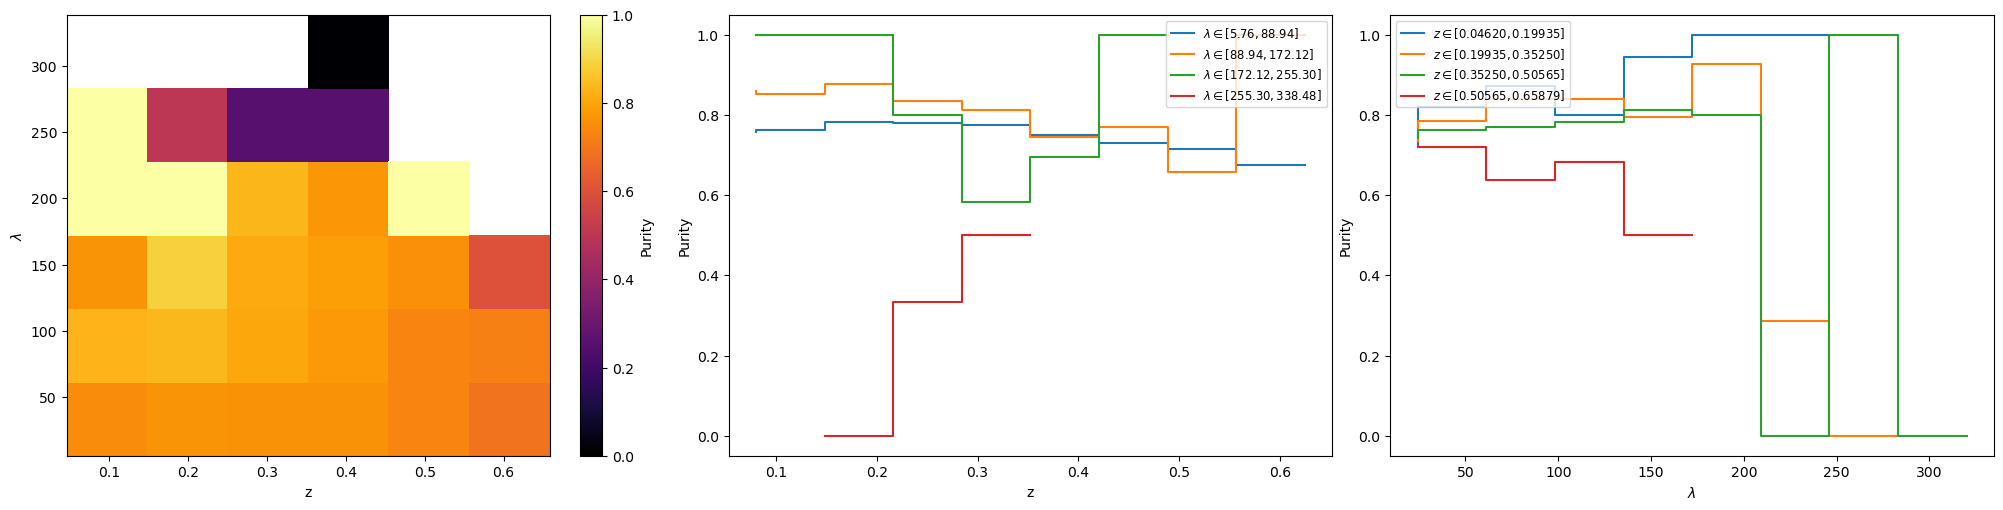

In [11]:
z_bin_1p_2d , R_bin_1p_2d, ratio_1p_2d = completness_purity(unique_detections_table , detections_table , z_2d , R_2d , 'z','R')

R_grid_1p_2d, z_grid_1p_2d = np.meshgrid(R_bin_1p_2d, z_bin_1p_2d)
C = ratio_1p_2d.reshape(len(R_grid_1p_2d),len(z_grid_1p_2d),)

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

fig.subplots_adjust(wspace=0.5)
fig.tight_layout()


c = ax1.pcolor(z_grid_1p_2d,R_grid_1p_2d,   C , cmap='inferno')
ax1.set_xlabel("z")
ax1.set_ylabel(r"$\lambda $")
fig.colorbar(c, ax=ax1, label='Purity',location='right')


z_bin_1p_z , R_bin_1p_z , ratio_1p_z = completness_purity(unique_detections_table , detections_table , z_z , R_z , 'z','R')

for i in range(len(R_bin_1p_z)):
    richness_bin = []
    for j in range(len(z_bin_1p_z)):
        richness_bin.append(ratio_1p_z[j][i])

    ax2.step(z_bin_1p_z ,richness_bin , label=r"$\lambda \in [%.2f ,%.2f]$" % (R_z[i] ,R_z[i+1]))
    ax2.set_xlabel("z")
    ax2.set_ylabel("Purity")
    ax2.legend(loc=1, bbox_to_anchor=(1, 1),fontsize='small')


z_bin_1p_R , R_bin_1p_R , ratio_1p_R = completness_purity(unique_detections_table , detections_table , z_R , R_R , 'z','R')

for i in range(len(z_bin_1p_R)):
    redshift_bin = []
    for j in range(len(R_bin_1p_R)):
        redshift_bin.append(ratio_1p_R[i][j])
        
    ax3.step(R_bin_1p_R ,redshift_bin , label=r"$z \in [%.5f ,%.5f]$" % (z_R[i] ,z_R[i+1]))
    ax3.set_xlabel(r"$\lambda$")
    ax3.set_ylabel("Purity")
    
    # Put a legend to the right of the current axis
    ax3.legend(loc="upper left",fontsize='small')
plt.show()


 ## Two-way Purity,
**Two-way Purity** $p(\lambda, z)$  measures the fraction of detected clusters that are associated  to true halos and have the halo associated to itself, serving as a metric to avoid false positives in the catalog within a specific richness range $\lambda$  and redshift $z$. It is calculated as follows [C. Knobel et al 2009 ApJ 697 1842](
    https://iopscience.iop.org/article/10.1088/0004-637X/697/2/1842/meta):

$$
p_2 = \frac{\mathcal{A}_2\left[ N^{det} \leftrightarrow  N^{halo} \right]}{N^{det}(\lambda,z)},
$$

Where: $\mathcal{A}_2\left[ N^{det} \leftrightarrow  N^{halo} \right]$: Number of detected clusters that are  two-way correctly m 
atched to true dark matter halos.
$ N^{det}(\lambda , z)  $: Total number of clusters detected by the algorithm within an observed richness range $\lambda$ and  redshift $z$.

/tmp/ipykernel_2078200/719555704.py:24: RuntimeWarning: invalid value encountered in divide
  ratio.append(cat1_number_bin2/cat2_number_bin2)


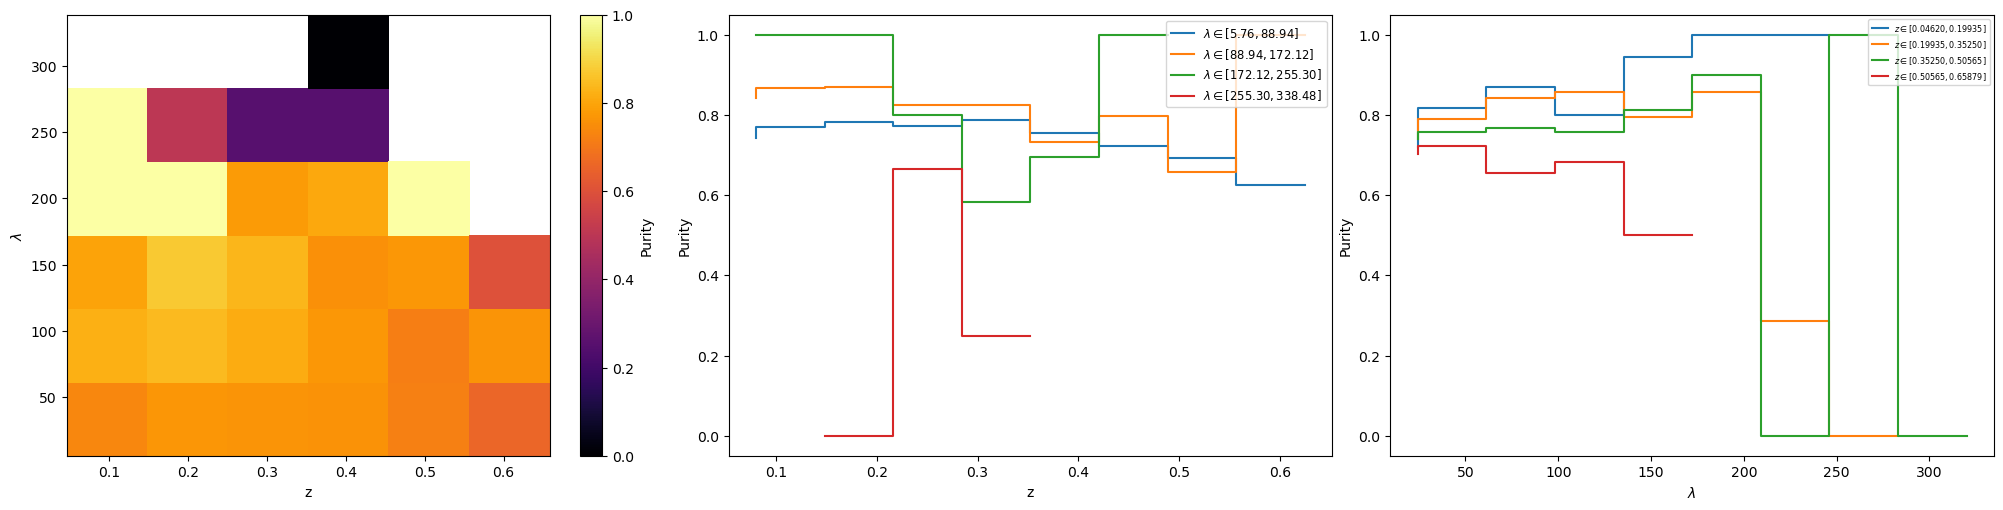

In [12]:
z_bin_2p_2d , R_bin_2p_2d, ratio_2p_2d = completness_purity(cross , detections_table , z_2d , R_2d , 'z','R')

R_grid_2p_2d, z_grid_2p_2d = np.meshgrid(R_bin_2p_2d, z_bin_2p_2d)
C = ratio_2p_2d.reshape(len(R_grid_2p_2d),len(z_grid_2p_2d),)

fig = plt.figure(figsize=(20,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

fig.subplots_adjust(wspace=0.5)
fig.tight_layout()


c = ax1.pcolor(z_grid_2p_2d,R_grid_2p_2d,   C , cmap='inferno')
ax1.set_xlabel("z")
ax1.set_ylabel(r"$\lambda $")
fig.colorbar(c, ax=ax1, label='Purity',location='right')


z_bin_2p_z , R_bin_2p_z , ratio_2p_z = completness_purity(cross , detections_table , z_z , R_z , 'z','R')

for i in range(len(R_bin_2p_z)):
    richness_bin = []
    for j in range(len(z_bin_2p_z)):
        richness_bin.append(ratio_2p_z[j][i])

    ax2.step(z_bin_2p_z ,richness_bin , label=r"$\lambda \in [%.2f ,%.2f]$" % (R_z[i] ,R_z[i+1]))
    ax2.set_xlabel("z")
    ax2.set_ylabel("Purity")
    ax2.legend(loc=1, bbox_to_anchor=(1, 1),fontsize='small')


z_bin_2p_R , R_bin_2p_R , ratio_2p_R = completness_purity(cross , detections_table , z_R , R_R , 'z','R')

for i in range(len(z_bin_2p_R)):
    redshift_bin = []
    for j in range(len(R_bin_2p_R)):
        redshift_bin.append(ratio_2p_R[i][j])
        
    ax3.step(R_bin_2p_R ,redshift_bin , label=r"$z \in [%.5f ,%.5f]$" % (z_R[i] ,z_R[i+1]))
    ax3.set_xlabel(r"$\lambda$")
    ax3.set_ylabel("Purity")
    
    # Put a legend to the right of the current axis
    ax3.legend(loc="upper right",fontsize='xx-small')
plt.show()

 ## Fragmentation
  The **Fragmentation** $F(\lambda, z)$ of a detection catalog is defined as the fraction of cluster detectios identified with multiple dark matter halos  by the algorithm within a specific richness range $\lambda$  and redshift $z$. It is calculated as follows [C. Knobel et al 2009 ApJ 697 1842](
    https://iopscience.iop.org/article/10.1088/0004-637X/697/2/1842/meta):
$$
F =  1- \frac{p_2(\lambda, z)}{p_1(\lambda, z)}
$$

/tmp/ipykernel_2078200/1465669161.py:1: RuntimeWarning: invalid value encountered in divide
  ratio_f_2d = np.array([ratio_2p_2d[i]/ratio_1p_2d[i] for i in range(len(ratio_2p_2d))])
/tmp/ipykernel_2078200/1465669161.py:21: RuntimeWarning: invalid value encountered in divide
  ratio_f_z = np.array([ratio_2p_z[i]/ratio_1p_z[i] for i in range(len(ratio_2p_z))])
/tmp/ipykernel_2078200/1465669161.py:35: RuntimeWarning: invalid value encountered in divide
  ratio_f_R = np.array([ratio_2p_R[i]/ratio_1p_R[i] for i in range(len(ratio_2p_R))])


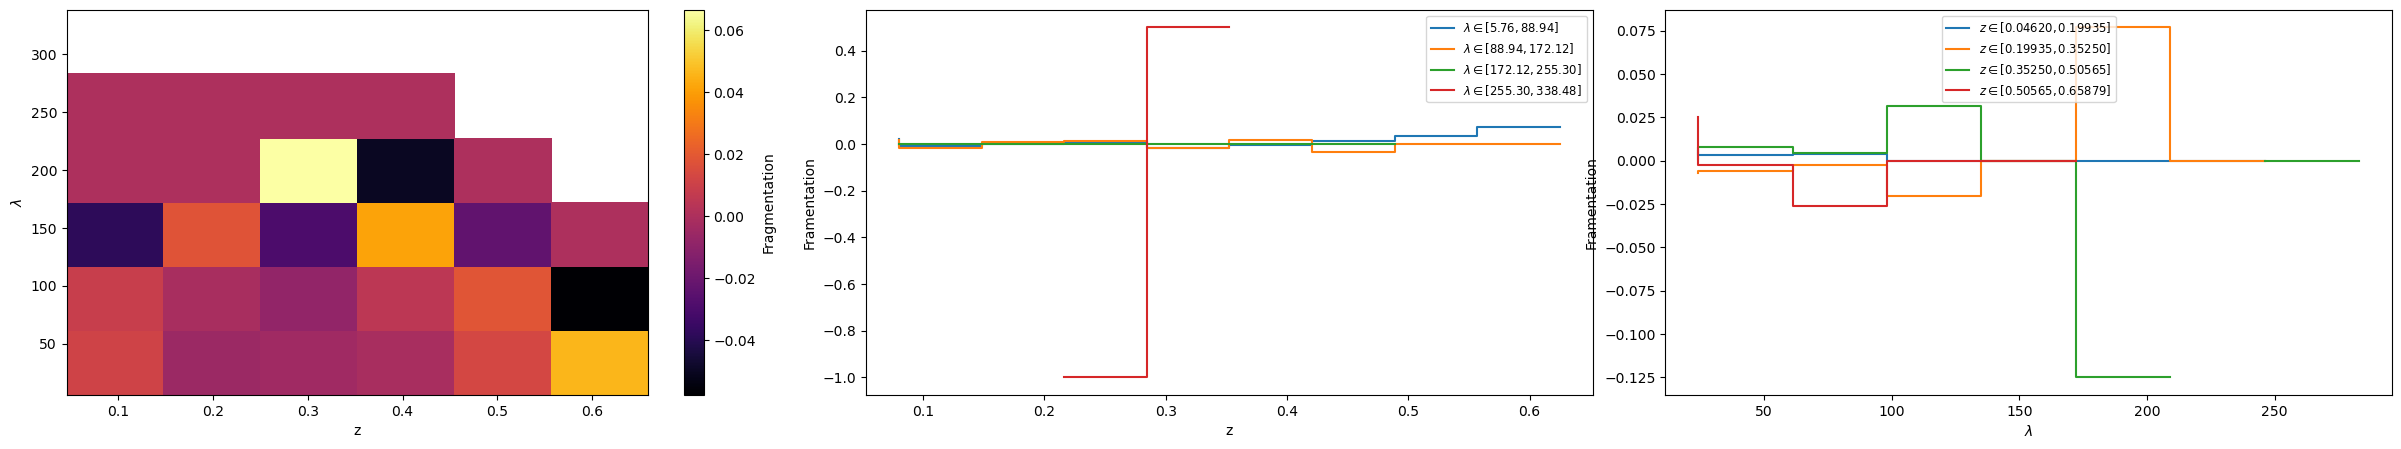

In [13]:
ratio_f_2d = np.array([ratio_2p_2d[i]/ratio_1p_2d[i] for i in range(len(ratio_2p_2d))])
ratio_f_2d = 1 -ratio_f_2d
R_grid_f_2d, z_grid_f_2d = np.meshgrid(R_bin_2p_2d, z_bin_2p_2d)
C = ratio_f_2d.reshape(len(R_bin_2p_2d),len(z_bin_2p_2d),)

fig = plt.figure(figsize=(30,5))
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
ax3 = fig.add_subplot(1,3,3)

fig.subplots_adjust(wspace=0.1)
#fig.tight_layout()


c = ax1.pcolor(z_grid_f_2d,R_grid_f_2d,   C , cmap='inferno')
ax1.set_xlabel("z")
ax1.set_ylabel(r"$\lambda $")
fig.colorbar(c, ax=ax1, label='Fragmentation',location='right')


ratio_f_z = np.array([ratio_2p_z[i]/ratio_1p_z[i] for i in range(len(ratio_2p_z))])
ratio_f_z = 1 -ratio_f_z

for i in range(len(R_bin_2p_z)):
    richness_bin = []
    for j in range(len(z_bin_2p_z)):
        richness_bin.append(ratio_f_z[j][i])

    ax2.step(z_bin_2p_z ,richness_bin , label=r"$\lambda \in [%.2f ,%.2f]$" % (R_z[i] ,R_z[i+1]))
    ax2.set_xlabel("z")
    ax2.set_ylabel("Framentation")
    ax2.legend(loc=1, bbox_to_anchor=(1, 1),fontsize='small')


ratio_f_R = np.array([ratio_2p_R[i]/ratio_1p_R[i] for i in range(len(ratio_2p_R))])
ratio_f_R = 1 -ratio_f_R

for i in range(len(z_bin_2p_R)):
    redshift_bin = []
    for j in range(len(R_bin_2p_R)):
        redshift_bin.append(ratio_f_R[i][j])
        
    ax3.step(R_bin_2p_R ,redshift_bin , label=r"$z \in [%.5f ,%.5f]$" % (z_R[i] ,z_R[i+1]))
    ax3.set_xlabel(r"$\lambda$")
    ax3.set_ylabel("Framentation")
    
    # Put a legend to the right of the current axis
    ax3.legend(loc="upper center",fontsize='small')
plt.show()